> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [Dataset-name]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected/downloaded for analysis. Read through the description available on the homepage-links present [here](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True). List all column names in each table, and their significance. In case of multiple tables, describe the relationship between tables. 

This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.

Column Names:

id                         
imdb_id                   
popularity                 
budget                     
revenue                    
original_title             
cast                      
homepage                
director                  
tagline                 
keywords                
overview                   
runtime                   
genres                    
production_companies    
release_date               
vote_count                 
vote_average               
release_year               
budget_adj                 
revenue_adj   




### Question(s) for Analysis
>**Tip**: Clearly state one or more questions that you plan on exploring over the course of the report. You will address these questions in the **data analysis** and **conclusion** sections. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

Exploratory data analysis shows that more total movies were produced every year since 1960. What are other trends observed in the dataset that correlate with movie production each year? Can these trends provide insight into the future of movie production and whether or not past trends are sustainable?

> **Tip**: Once you start coding, use NumPy arrays, Pandas Series, and DataFrames where appropriate rather than Python lists and dictionaries. Also, **use good coding practices**, such as, define and use functions to avoid repetitive code. Use appropriate comments within the code cells, explanation in the mark-down cells, and meaningful variable names. 

In [71]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


In [55]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas

Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (1.1.5)


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [72]:
# Load your data and print out a few lines. Perform operations to inspect data
# types and look for instances of missing or possibly errant data.

url = ('https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv')
movies = pd.read_csv(url)
movies.head() 



,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [73]:
print('Describe-----------------------------------------')
print(movies.describe())
#Summary of dataframe
print('Info-----------------------------------------')
print(movies.info())
#Returns the first 5 rows of object
print('Head-----------------------------------------')
print(movies.head(5))
#Returns the last 5 rows of object
print('Tail--------------------------------------------------')
print(movies.tail(5))
print('--------------------------------------------------')


Describe-----------------------------------------
                  id    popularity        budget       revenue       runtime  \
count   10866.000000  10866.000000  1.086600e+04  1.086600e+04  10866.000000   
mean    66064.177434      0.646441  1.462570e+07  3.982332e+07    102.070863   
std     92130.136561      1.000185  3.091321e+07  1.170035e+08     31.381405   
min         5.000000      0.000065  0.000000e+00  0.000000e+00      0.000000   
25%     10596.250000      0.207583  0.000000e+00  0.000000e+00     90.000000   
50%     20669.000000      0.383856  0.000000e+00  0.000000e+00     99.000000   
75%     75610.000000      0.713817  1.500000e+07  2.400000e+07    111.000000   
max    417859.000000     32.985763  4.250000e+08  2.781506e+09    900.000000   

         vote_count  vote_average  release_year    budget_adj   revenue_adj  
count  10866.000000  10866.000000  10866.000000  1.086600e+04  1.086600e+04  
mean     217.389748      5.974922   2001.322658  1.755104e+07  5.136436e+

In [74]:
# Showing null columns
movies.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64


### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [75]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

#Changing Data Types
change_type=['budget_adj', 'revenue_adj']
#changing data type
movies[change_type]=movies[change_type].applymap(np.int64)
#printing the changed information
movies.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj                int64
revenue_adj               int64
dtype: object

In [76]:
#Dropping unused columns
movies = movies.drop(['cast', 'imdb_id', 'tagline', 'budget', 'revenue', 'homepage', 'keywords', 'overview', 'production_companies', 'release_date', 'genres' ], axis = 1)
movies.columns

Index(['id', 'popularity', 'original_title', 'director', 'runtime',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

In [77]:
#Dropping duplicate rows
movies = movies.drop_duplicates()

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8922139e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe8920489b0>]], dtype=object)

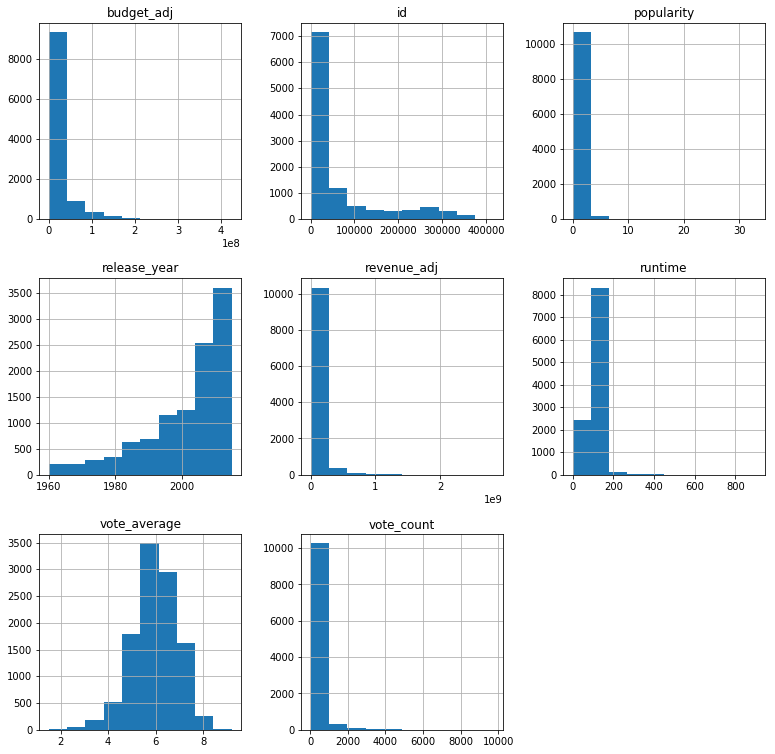

In [78]:
# Showing distribution of variables

movies.hist(figsize=(13,13))

The above figure shows histogram distributions for budget, revenue, release year, vote average and vote count. 

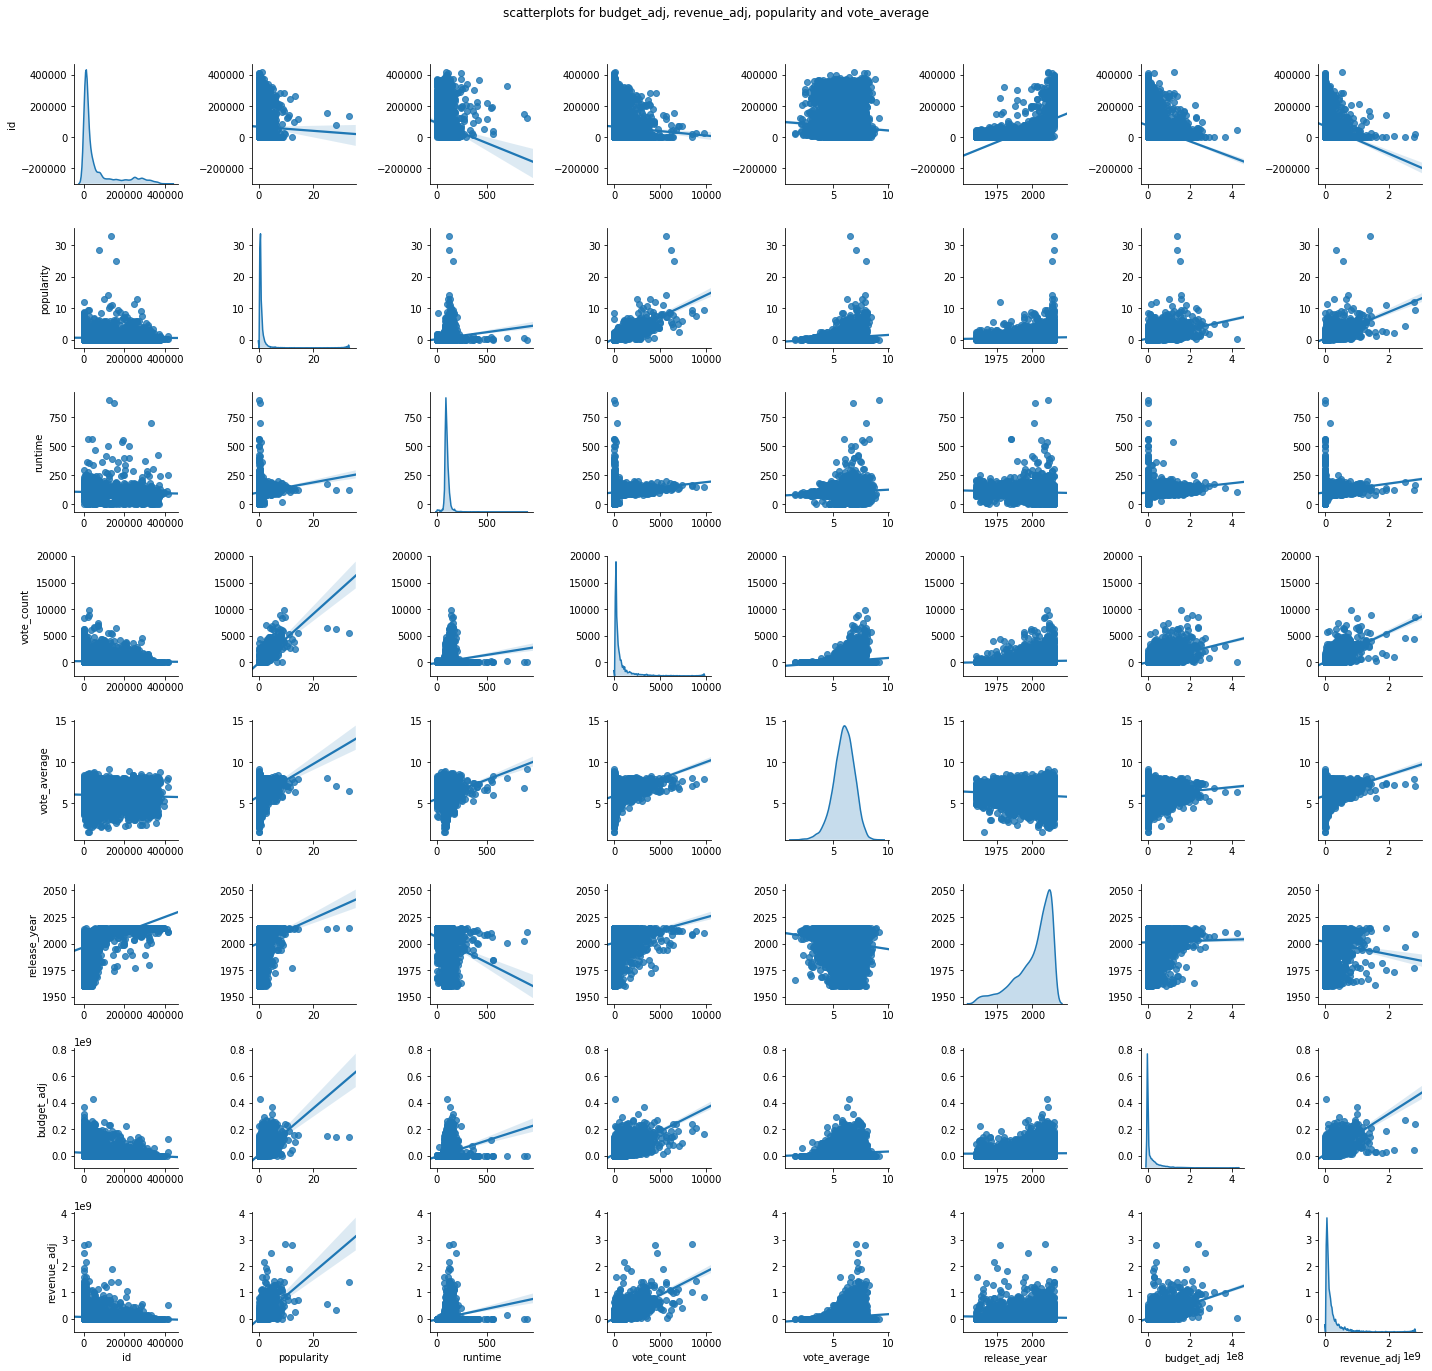

In [82]:
fig1 = sns.pairplot(movies, kind="reg", diag_kind="kde", diag_kws=dict(shade=True))
fig1.fig.suptitle('scatterplots for budget_adj, revenue_adj, popularity and vote_average\n')
fig1.fig.tight_layout(rect=[0, 0.03, 1, 0.95])



The above figure shows scatter plots for variable combinations in the dataset. Regression lines are included to show correlations. Particularly, revenue_adj vs. budget_adj confirms that there is a positive correlation between budget and revenue in the dataset.

### Research Question 1 How did Budget change over time?

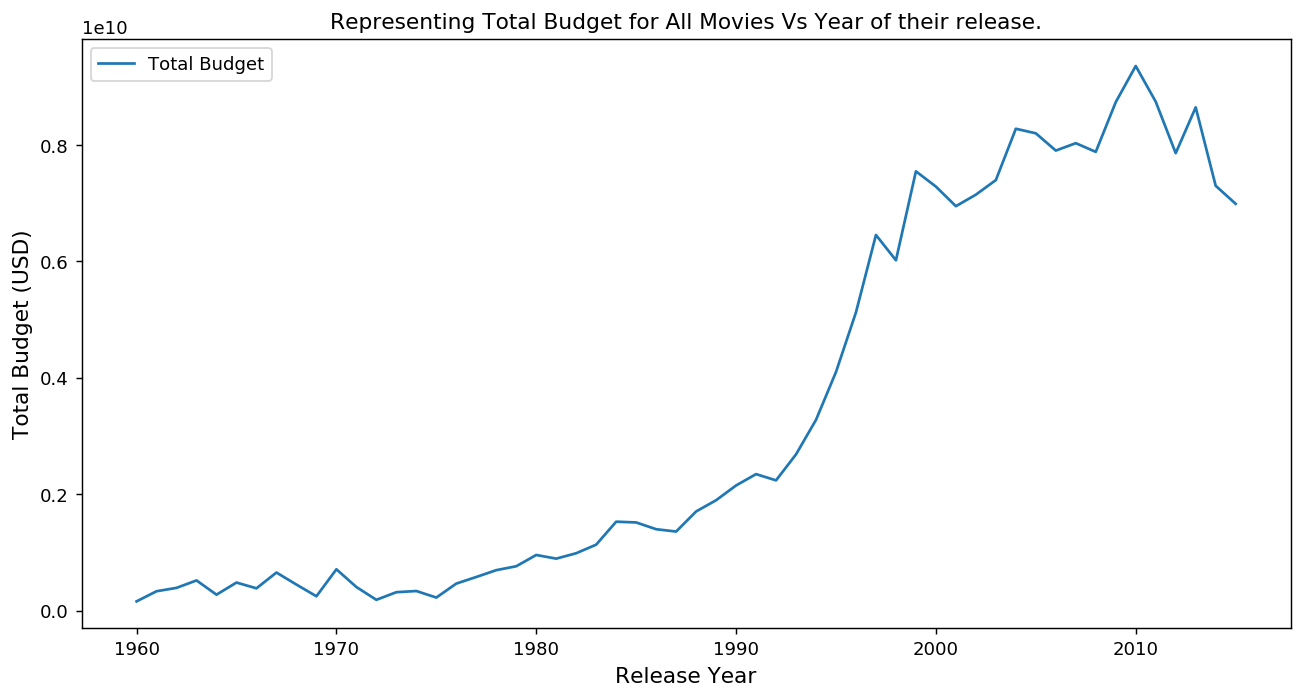

In [26]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

#Creating line plots

budget_year = movies.groupby('release_year')['budget_adj'].sum()

#figure size(width, height)
plt.figure(figsize=(12,6), dpi = 130)

#on x-axis
plt.xlabel('Release Year', fontsize = 12)
#on y-axis
plt.ylabel('Total Budget (USD)', fontsize = 12)
#title of the line plot
plt.title('Representing Total Budget for All Movies Vs Year of their release.')

#plotting the graph
plt.plot(budget_year, label = 'Total Budget')

plt.legend()
#displaying the line plot
plt.show()



The above line chart shows total budget for all movies each year. There is a positive trend until about year 2000 when the rate of change begins to decrease. Total budget decreases after 2010, representing less funding each year. 

### Research Question 2  How did Profit change over time?

In [16]:
# Continue to explore the data to address your additional research questions. Add more headers as needed if you have more questions to investigate.

# Creat new variable- Profit Earned
movies.insert(2,'profit_earned',movies['revenue_adj']-movies['budget_adj'])

#previewing the changes in the dataset
movies.head(2)

,id,popularity,profit_earned,original_title,director,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.985763,1254445953,Jurassic World,Colin Trevorrow,124,5562,6.5,2015,137999939,1392445892
1,76341,28.419936,210161353,Mad Max: Fury Road,George Miller,120,6185,7.1,2015,137999939,348161292


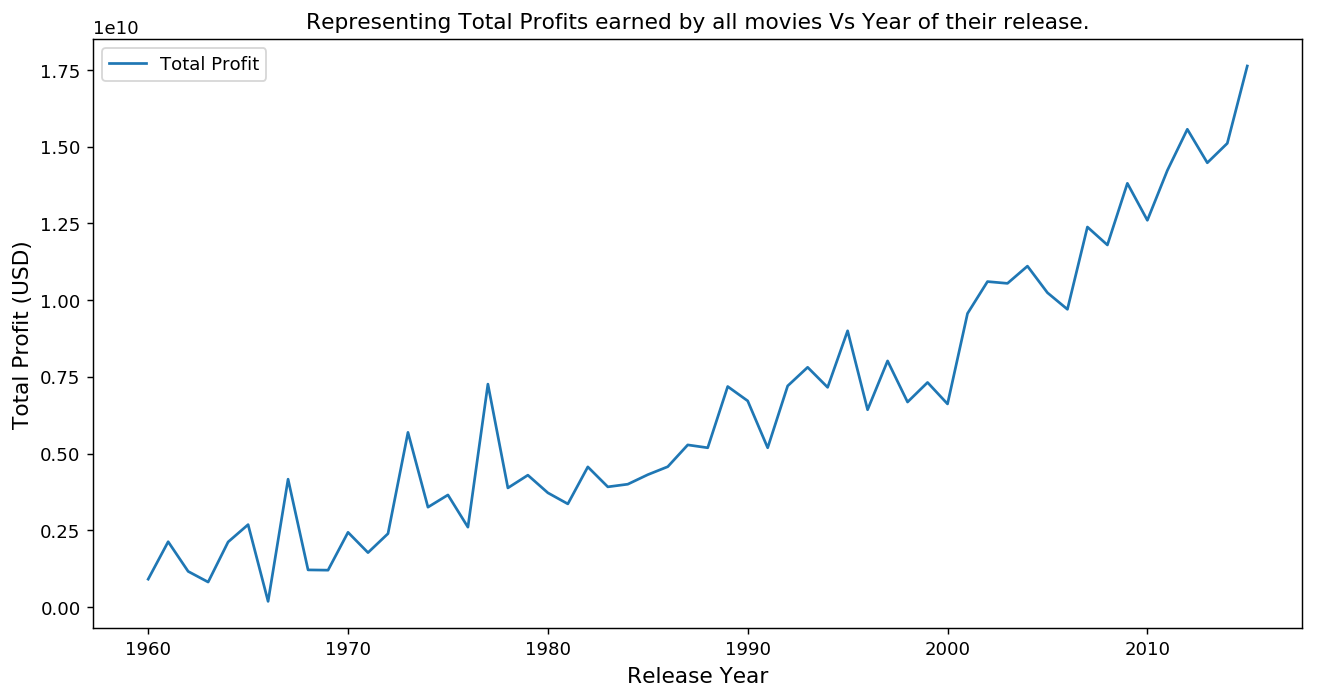

In [25]:
#We will be using Line plot for this analysis
#Since we want to know the profits of movies for every year therefore we have to sum up all the movies of a particular year

profits_year = movies.groupby('release_year')['profit_earned'].sum()

#figure size(width, height)
plt.figure(figsize=(12,6), dpi = 130)

#on x-axis
plt.xlabel('Release Year', fontsize = 12)
#on y-axis
plt.ylabel('Total Profit (USD)', fontsize = 12)
#title of the line plot
plt.title('Representing Total Profits earned by all movies Vs Year of their release.')

#plotting the graph
plt.plot(profits_year, label = 'Total Profit')

#displaying the line plot
plt.legend()
plt.show()

The above line chart shows total profit for all movies each year. There is a positive trend during the entire period from 1960 to 2015. Thus, the  movie industry has continued to earn greater profits every year since 1960. 

In [69]:
### Research Question 3: Is there relationship between Profit and Budget?

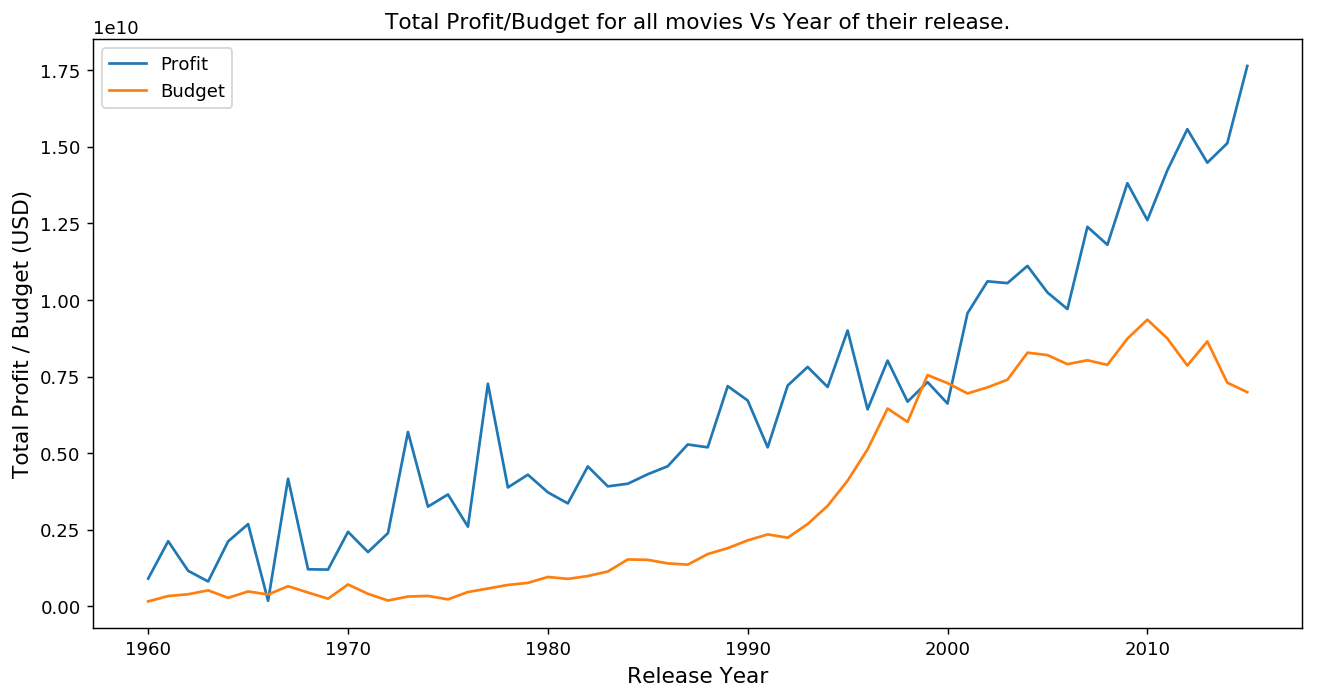

In [29]:
#We will be using Line plot for this analysis
#Since we want to know the profits of movies for every year therefore we have to sum up all the movies of a particular year

profits_year = movies.groupby('release_year')['profit_earned'].sum()

#figure size(width, height)
plt.figure(figsize=(12,6), dpi = 130)

#on x-axis
plt.xlabel('Release Year', fontsize = 12)
#on y-axis
plt.ylabel('Total Profit / Budget (USD)', fontsize = 12)
#title of the line plot
plt.title('Total Profit/Budget for all movies Vs Year of their release.')

#plotting the graph
plt.plot(profits_year, label = 'Profit')
plt.plot(budget_year, label = 'Budget')

#displaying the line plot
plt.legend()
plt.show()

The above line chart shows both total profit and total budget for all movies each year. After year 2000, total budget decreases while profit continues to rise. Thus, movies have continued to earn greater profit despite receiving less funding. 

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.


> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying c
ausation from correlation!

Data Exploration shows that more movies are produced every year. Total budgets also increase until about year 2000 when the rate of change peaks. Total budget decreases after 2010, but profits continue to rise. 

Regression plots show that budget is positively correlated with revenue. Higher budgets tend to produce more  revenue. Yet this conflicts with my previous observation of decreasing budgets and rising profits. Therefore, there may be additional characteristics of the dataset that could further explain the relationship between budget and revenue/profit.

Regression analysis confirms a positive correlation between budget and revenue, so increased profits may be better explained by the diversity of movies produced each year rather than lower expenses. This analysis shows that the overall movie industry may be more profitable when funds are distributed to more projects rather than fewer. Future analysis would examine the composition of movies produced each year and its effects on profit while controlling for budget amounts.


### Limitations
> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

The results are limited to underlying data set. No advanced statistics were performed, the results can only be treated as indicators and are not generalizable. Many entries in the dataset have been removed due to missing data.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [83]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0